In [1]:
import numpy as np
from SLIP import Image, imread

import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


## example image

In [2]:
im = Image(pe='https://raw.githubusercontent.com/bicv/SLIP/master/default_param.py')
image = im.imread('http://natural-scenes.cps.utexas.edu/kodakdb/images/yose07.png')

In [3]:
print('Size of image', image.shape)

Size of image (480, 480)


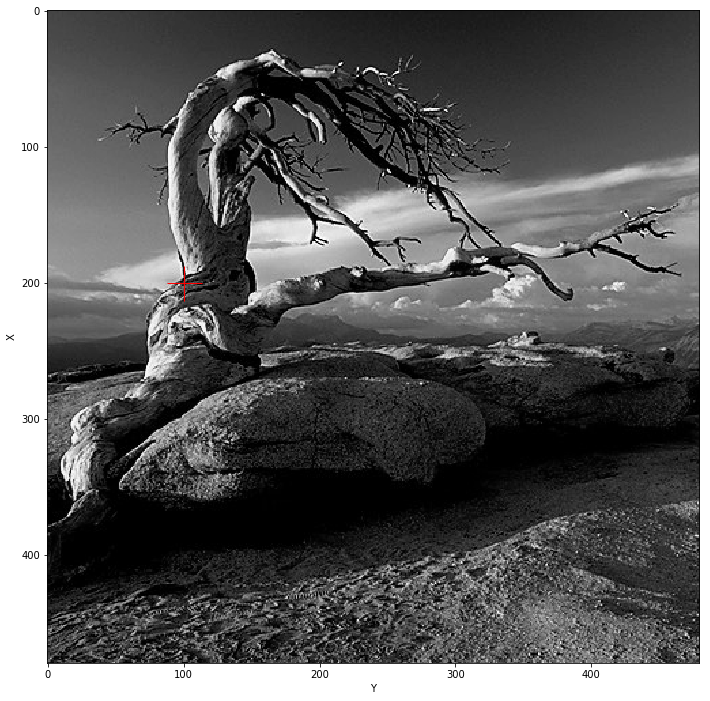

In [4]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(image, cmap=plt.gray())
center = (200, 100) # X, Y
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.plot(center[1], center[0], 'r+', ms=35);

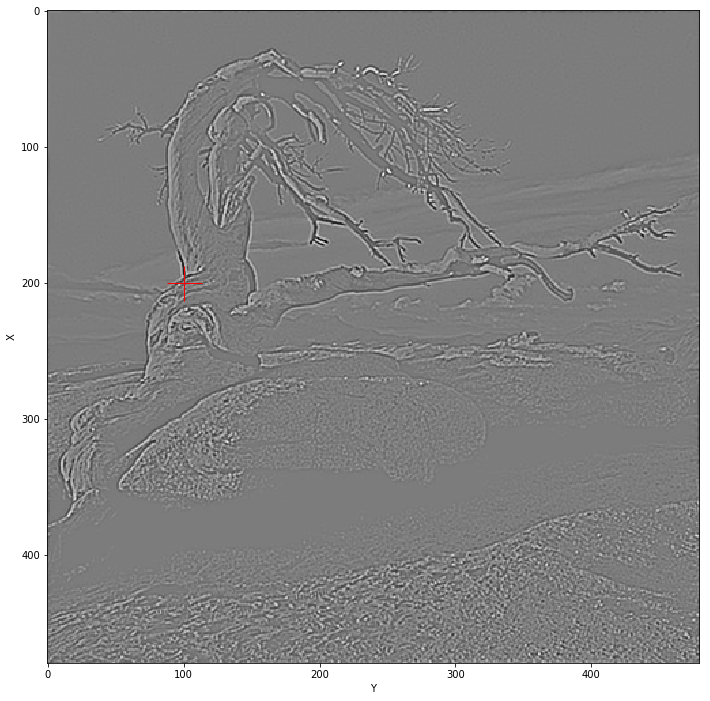

In [5]:
white = im.whitening(image)
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(white, cmap=plt.gray())
center = (200, 100) # X, Y
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.plot(center[1], center[0], 'r+', ms=35);

In [6]:
N_X, N_Y = 128, 128
up = int(center[0]-N_X/2)
left = int(center[1]-N_Y/2)
crop = white[up:(up+N_X), left:(left+N_Y)]

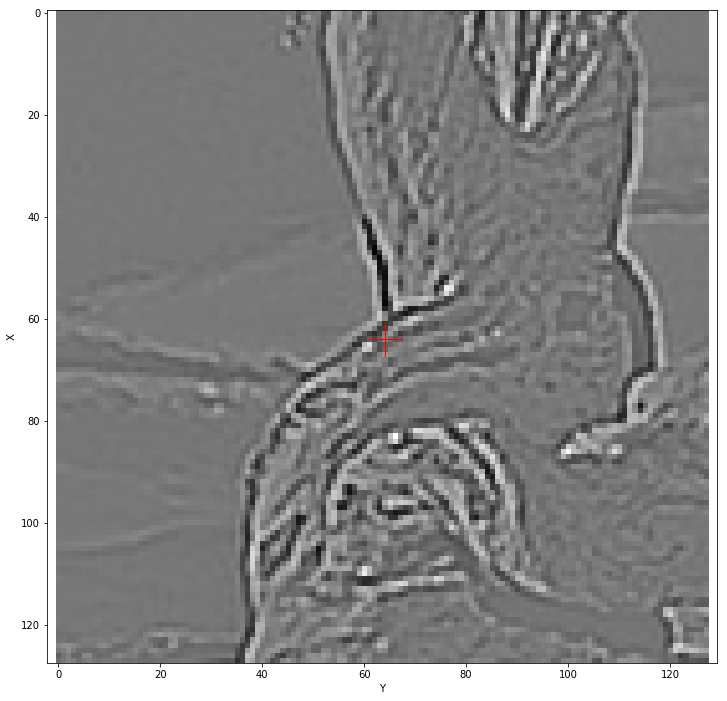

In [7]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(crop, cmap=plt.gray())
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.plot([N_Y/2], [N_X/2], 'r+', ms=35)
ax.axis('equal');

## Defining oriented filters

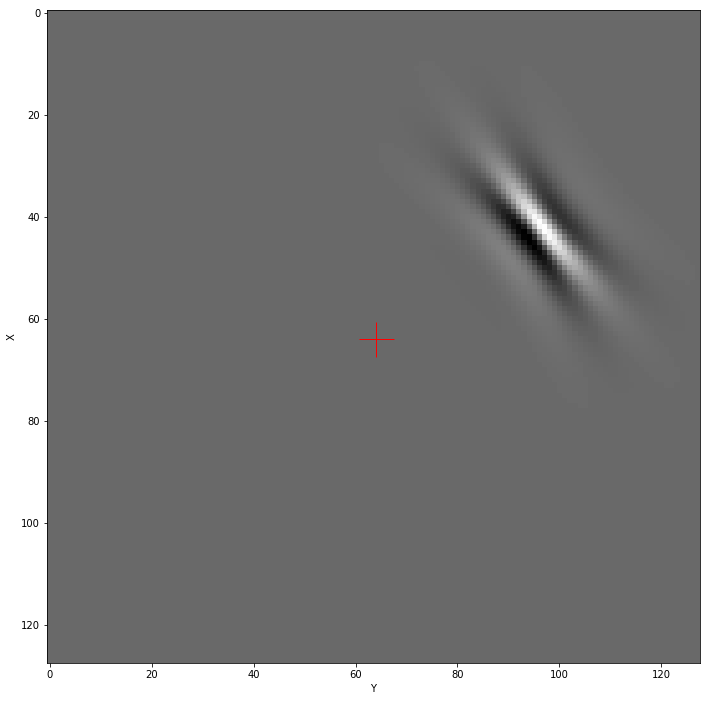

In [9]:
from LogGabor import LogGabor
parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
lg = LogGabor(parameterfile)
lg.set_size((N_X, N_Y))
params= {'sf_0':.1, 'B_sf': lg.pe.B_sf, 'theta':np.pi* 5 / 7., 'B_theta': lg.pe.B_theta}
phase = np.pi/4
edge = lg.normalize(lg.invert(lg.loggabor(N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(edge, cmap=plt.gray())
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.plot([N_Y/2], [N_X/2], 'r+', ms=35);

In [10]:
print('Different ways to compute the scalar product = ', (edge*crop).sum() , edge.ravel().T @ crop.ravel() )

Different ways to compute the scalar product =  0.623897356898 0.623897356898


## Vectorizing

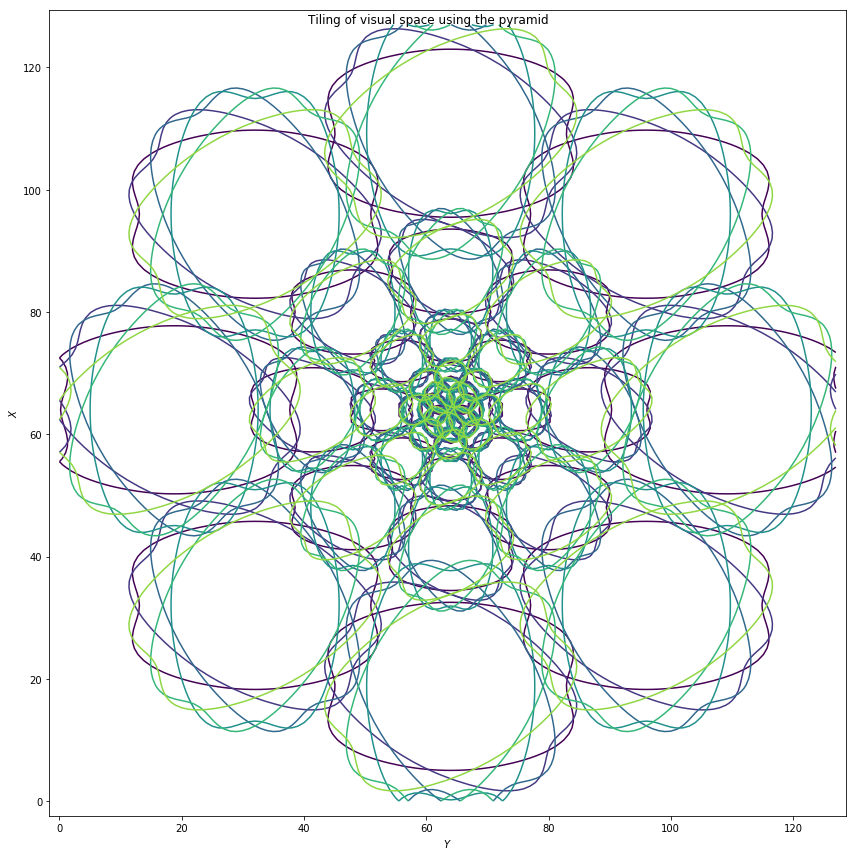

In [11]:
N_theta, N_orient, N_scale, N_phase = 6, 8, 5, 2
phi = np.zeros((N_theta, N_orient, N_scale, N_phase, N_X*N_Y))

for i_theta in range(N_theta):
    for i_orient in range(N_orient):
        for i_scale in range(N_scale):
            ecc =  .5**(N_scale - i_scale)
            r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc # radius
            sf_0 = 0.5 * 0.03 / ecc
            #print('radius=', r, 'at scale', i_scale, 'with sf_0=', sf_0 , 'ecc', ecc)
            x = N_X/2 + r * np.cos(i_orient*np.pi*2 / N_orient)
            y = N_Y/2 + r * np.sin(i_orient*np.pi*2 / N_orient)            
            for i_phase in range(N_phase):
                params= {'sf_0':sf_0, 'B_sf': lg.pe.B_sf, 'theta':i_theta*np.pi/N_theta, 'B_theta': np.pi/N_theta/2}
                #print('At', i_theta, i_orient, i_scale, i_phase, 'x, y=', x, y, 'params=', params)
                phase = i_phase * np.pi/2
                phi[i_theta, i_orient, i_scale, i_phase, :] = lg.normalize(lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel()            

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
for i_theta in range(N_theta):
    for i_orient in range(N_orient):
        for i_scale in range(N_scale):
            env = np.sqrt(phi[i_theta, i_orient, i_scale, 0, :]**2 + phi[i_theta, i_orient, i_scale, 1, :]**2).reshape((N_X, N_Y))
            ax.contour(env, levels=[env.max()/2], lw=1, colors=[plt.cm.viridis(i_theta/(N_theta))])
fig.suptitle('Tiling of visual space using the pyramid')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout();

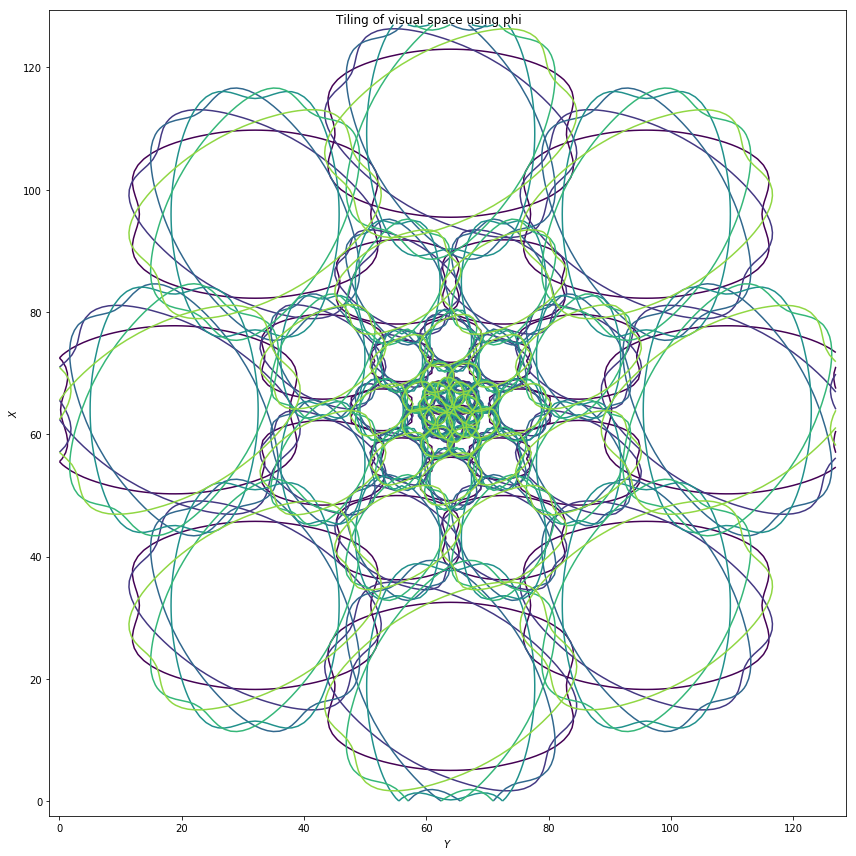

In [12]:
N_theta, N_orient, N_scale, N_phase = 6, 8, 5, 2
phi = np.zeros((N_theta, N_orient, N_scale, N_phase, N_X*N_Y))

for i_theta in range(N_theta):
    for i_orient in range(N_orient):
        for i_scale in range(N_scale):
            ecc =  .5**(N_scale - i_scale)
            r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc # radius
            sf_0 = 0.5 * 0.03 / ecc
            #print('radius=', r, 'at scale', i_scale, 'with sf_0=', sf_0 , 'ecc', ecc)
            x = N_X/2 + r * np.cos((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)
            y = N_Y/2 + r * np.sin((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)            
            for i_phase in range(N_phase):
                params= {'sf_0':sf_0, 'B_sf': lg.pe.B_sf, 'theta':i_theta*np.pi/N_theta, 'B_theta': np.pi/N_theta/2}
                #print('At', i_theta, i_orient, i_scale, i_phase, 'x, y=', x, y, 'params=', params)
                phase = i_phase * np.pi/2
                phi[i_theta, i_orient, i_scale, i_phase, :] = lg.normalize(lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel()            

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
for i_theta in range(N_theta):
    for i_orient in range(N_orient):
        for i_scale in range(N_scale):
            env = np.sqrt(phi[i_theta, i_orient, i_scale, 0, :]**2 + phi[i_theta, i_orient, i_scale, 1, :]**2).reshape((N_X, N_Y))
            ax.contour(env, levels=[env.max()/2], lw=1, colors=[plt.cm.viridis(i_theta/(N_theta))])
fig.suptitle('Tiling of visual space using phi')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout();

In [12]:
corr = phi @ crop.ravel()
print('All scalar products in one shot = ', (corr).shape )

All scalar products in one shot =  (6, 8, 5, 2)


In [22]:
print('Shape of phi=', phi.shape)
phi_ravel = phi.reshape((N_theta*N_orient*N_scale*N_phase, N_X*N_Y))
print('Shape of phi_mat=', phi_ravel.shape)
print('Shape of phi=', phi_ravel.reshape((N_theta, N_orient, N_scale, N_phase, N_X*N_Y)).shape)

Shape of phi= (6, 8, 5, 2, 16384)
Shape of phi_mat= (480, 16384)
Shape of phi= (6, 8, 5, 2, 16384)


In [23]:

corr_ravel = phi_ravel @ crop.ravel()


phi_plus = np.linalg.pinv(phi_ravel)
crop_hat = phi_plus @ corr_ravel

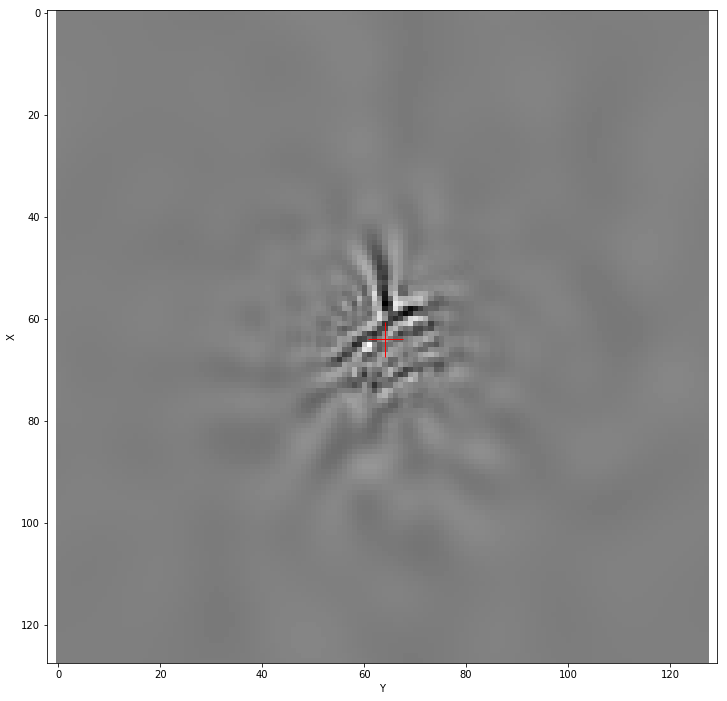

In [24]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(crop_hat.reshape((N_X, N_Y)), cmap=plt.gray())
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.plot([N_Y/2], [N_X/2], 'r+', ms=35)
ax.axis('equal');

Tiling of visual space using the pyramid

In [14]:
energy = (corr**2).sum(axis=-1)
print('Shape of energy = ', energy.shape )

Shape of energy =  (6, 8, 5)


In [15]:
global_energy = (corr**2).sum(axis=(0, -1))
print('Shape of global_energy = ', global_energy.shape )

Shape of global_energy =  (8, 5)


à vérifier car il y a 8 dirtections et 5 scales pas l'inverse! : 

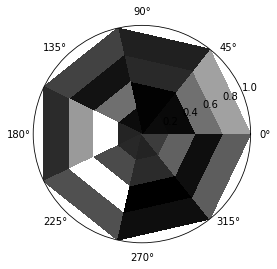

In [16]:
r, theta = np.meshgrid(np.linspace(0, 1, N_scale), np.linspace(0, 2*np.pi, N_orient))
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.pcolor(theta, r, global_energy);

je n'arrive pas à plotter en polaire une imahge en couleur... peut être avec https://matplotlib.org/devdocs/gallery/images_contours_and_fields/layer_images.html#sphx-glr-gallery-images-contours-and-fields-layer-images-py ?? : 

Shape of color_energy =  (8, 5, 3)


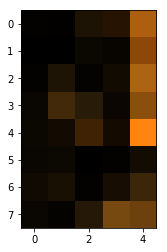

In [17]:
color_energy = np.zeros((N_orient, N_scale, 3))
for i_theta in range(N_theta):
    color = np.array([1 + np.cos(i_theta/N_theta + i*np.pi/3) for i in np.arange(3)])
    color_energy += energy[i_theta, :, :][:, :, np.newaxis] * color[np.newaxis, np.newaxis, :]
print('Shape of color_energy = ', color_energy.shape )
color_energy /= color_energy.max()
r, theta = np.meshgrid(np.linspace(0, 1, N_scale), np.linspace(0, 2*np.pi, N_orient))
fig, ax = plt.subplots()#subplot_kw=dict(projection='polar'))
#ax.pcolormesh(theta, r, color_energy);
ax.imshow(color_energy);

## making it a class

In [18]:
import numpy as np
from SLIP import Image, imread

import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
fig_width = 12
figsize=(fig_width, .618*fig_width)

class LogPolarTransform:
    
    def __init__(self, p):
        self.p = p
        try:
            self.phi = np.load(self.p['filename_phi_cache'])
        except:
            self.phi = self.init_phi()
            
    def init_phi(self):
        
        
        np.save(self.p['filename_phi_cache'], phi)
        return phi
    
    def code(self, image):
        return self.phi @ image.ravel()
    
    